<a href="https://colab.research.google.com/github/eliasingi12/DEEP_U-net_Project/blob/master/DEEP_run_test_with_greyscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -L -o DRIVE.zip "https://drive.google.com/uc?export=download&id=1aSJuBxtklXelBJEt-kvG32QQYO1BIQyP"
!unzip DRIVE.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    111      0 --:--:--  0:00:03 --:--:--   111
100 28.6M    0 28.6M    0     0  6969k      0 --:--:--  0:00:04 --:--:--  188M
Archive:  DRIVE.zip
replace DRIVE/test/mask/12_test_mask.gif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: DRIVE/test/mask/12_test_mask.gif  
 extracting: DRIVE/test/mask/10_test_mask.gif  
 extracting: DRIVE/test/mask/08_test_mask.gif  
 extracting: DRIVE/test/mask/06_test_mask.gif  
 extracting: DRIVE/test/mask/04_test_mask.gif  
 extracting: DRIVE/test/mask/01_test_mask.gif  
 extracting: DRIVE/test/mask/05_test_mask.gif  
 extracting: DRIVE/test/mask/13_test_mask.gif  
 extracting: DRIVE/test/mask/02_test_mask.gif  
 extracting: DRIVE/test/mask/19_test_mask.gif  
 extracting: DRIVE/test/mask/15_test_mask.gif  
 extracting: DRIVE/test/mask/16_test_mask.gif  
 extra

In [0]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


def weighted_dice_coeff(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return score


def weighted_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 1 - weighted_dice_coeff(y_true, y_pred, weight)
    return loss


def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
                                          (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)


def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + (1 - weighted_dice_coeff(y_true, y_pred, weight))
    return loss

In [0]:
import os  # misc operating system specific operations, e.g., reading directries.
import sys
import random

import cv2
import numpy as np

import matplotlib.pyplot as plt

#from unet import unet

#resize inputs & targets
import skimage
from skimage.transform import resize

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.optimizers import SGD
from sklearn.metrics import classification_report

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop

#!pip install fcn==6.4.4

In [0]:
# Some parameters and paths to data
#dir_path = os.path.dirname(os.path.realpath(__file__))
path_train = 'DRIVE/training/'
path_test = 'DRIVE/test/'
path_img = 'images'
path_mask = 'mask'
path_targets = '1st_manual'
path_tif_targets = '1st_manual_tif'
# pre_dir = "/content/drive/My Drive/DRIVE/"

In [55]:
# Read in the file paths of the images to use for the training.
random_seed = 42
sz = 64
image_paths = []
target_paths = []

args = {}
args["training_imgs"] = "DRIVE/training/images"
args["targets"] = "DRIVE/training/1st_manual_tif"

for (dirpath, dirnames, filenames) in os.walk(args["training_imgs"]):
    for file in filenames:
        if '.tif' in file and not file.startswith('.'):
              image_paths.append(os.path.join(dirpath, file))

for (dirpath, dirnames, filenames) in os.walk(args["targets"]):
    for file in filenames:
        if '.tiff' in file and not file.startswith('.'):
              target_paths.append(os.path.join(dirpath, file))
            
                
random.seed(random_seed)

def show_images(imgs, grid_size=3):
    f, axarr = plt.subplots(grid_size,grid_size, figsize=(15, 15))
    for i in range(grid_size):
        for j in range(grid_size):
            axarr[i,j].imshow(imgs[i*grid_size+j])
    plt.show()
  

image_paths.sort()
input_data = []
for image_path in image_paths:
    image = cv2.imread(image_path,0) # 0 -> greyscale
    image = np.resize(image, (512, 512, 1))
    #image = cv2.resize(image, (512, 512))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    input_data.append(image)
    
target_paths.sort()
target_data = []
for target_path in target_paths:
    target = cv2.imread(target_path,0)
    target = np.resize(target, (512, 512, 1))
    #target = cv2.resize(target, (512, 512))
    #target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    target_data.append(target)

#input_data   = np.array(input_data, dtype="float") / 255.0
#target_data   = np.array(target_data, dtype="float") / 255.0

print(input_data[0].shape)    
print(target_data[0].shape)

#show_images(input_data)

input_data = np.array(input_data)/255
target_data = np.array(target_data)/255

print(input_data.shape)
print(target_data.shape)

def fix_mask(mask):
    mask[mask < 100] = 0
    mask[mask >= 100] = 1

fix_mask(target_data)
#print(input_data)   




(512, 512, 1)
(512, 512, 1)
(20, 512, 512, 1)
(20, 512, 512, 1)


In [0]:
#print(target_data)

In [0]:
#show_images(input_data)


In [0]:
#show_images(target_data)

In [0]:
def get_unet_512(input_shape=(512, 512, 1),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 512

    down0a = Conv2D(16, (3, 3), padding='same')(inputs)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a = Conv2D(16, (3, 3), padding='same')(down0a)
    down0a = BatchNormalization()(down0a)
    down0a = Activation('relu')(down0a)
    down0a_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0a)
    # 256

    down0 = Conv2D(32, (3, 3), padding='same')(down0a_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    # 256

    up0a = UpSampling2D((2, 2))(up0)
    up0a = concatenate([down0a, up0a], axis=3)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    up0a = Conv2D(16, (3, 3), padding='same')(up0a)
    up0a = BatchNormalization()(up0a)
    up0a = Activation('relu')(up0a)
    # 512

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [56]:
#h,w,ch = target_data[0].shape

#print(target_data[0].shape)
#print(input_data[0].shape)
#show_images(target_data)

EPOCHS=5

model = get_unet_512()
#model.summary()

#input_data = np.array(input_data)
#target_data = np.array(target_data)
print(target_data.shape)
print(input_data.shape)

#target_data = np.expand_dims(target_data, axis=2)
#print(target_data.shape)


#input_data = np.reshape(input_data, (20,584,565,3))

model.fit(input_data, target_data, epochs=EPOCHS, batch_size=1)

(20, 512, 512, 1)
(20, 512, 512, 1)
Epoch 1/5
20/20 [==============================] - 30s 1s/step - loss: 0.9673 - acc: 0.2460
Epoch 2/5
20/20 [==============================] - 6s 293ms/step - loss: 0.6631 - acc: 0.6789
Epoch 3/5
20/20 [==============================] - 6s 293ms/step - loss: 0.5807 - acc: 0.8736
Epoch 4/5
20/20 [==============================] - 6s 293ms/step - loss: 0.5191 - acc: 0.9530
Epoch 5/5
20/20 [==============================] - 6s 293ms/step - loss: 0.4788 - acc: 0.9861


(512, 512, 1)
(1, 512, 512, 1)
(1, 512, 512, 1)
(512, 512, 1)


IndexError: ignored

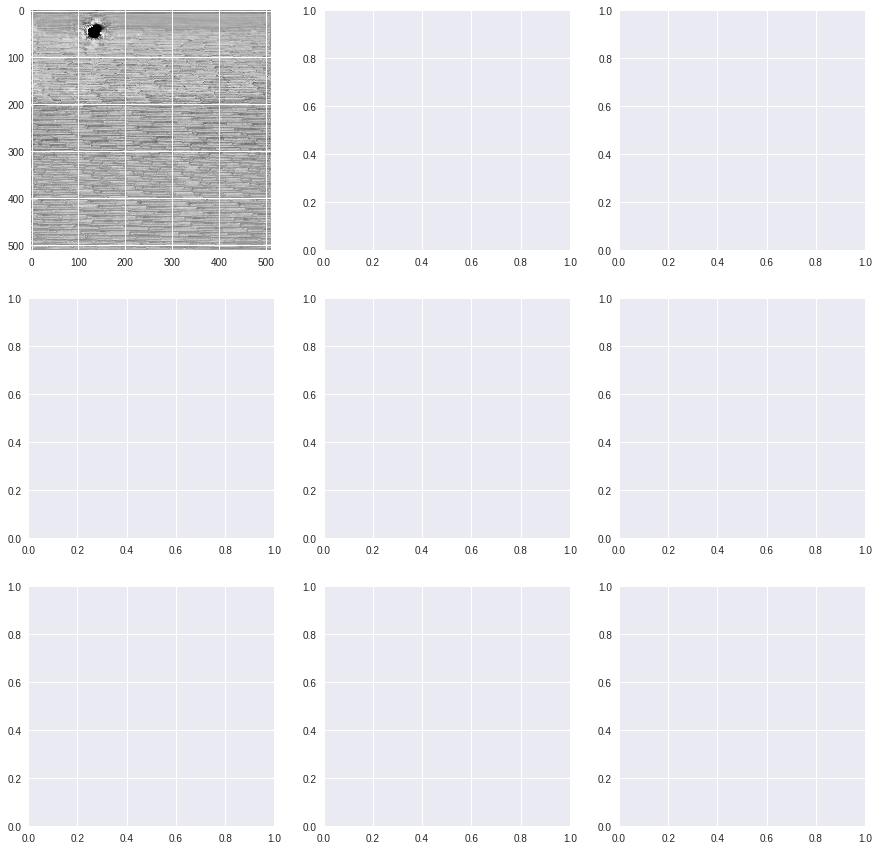

In [67]:
pred_arr = input_data[0]
print(pred_arr.shape)
pred_arr = np.expand_dims(pred_arr, axis=0)
print(pred_arr.shape)
outp = model.predict(pred_arr, batch_size=1)
print(outp.shape)
#print(outp)
outp = outp.reshape((512,512,1))
print(outp.shape)
outp = outp.reshape((512,512))
show_images([outp])